In [46]:
using CairoMakie
using Statistics
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets, NonlinearSolve

In [2]:
include("src/parameters.jl")
include("src/filament_state.jl")

Ri_min (generic function with 1 method)

┌ Info: Created simulation parameters
│ Input:
│  Ro=0.8
│  Ri=0.01
│  Ek=0
│  α=1.5
│  λ=0.05
│  δ=-0.25
│  β=0.1
│ Output:
│  L=1
│  f=1
│  H=0.1
│  δH=-0.025
│  N₀=47.677643892862804
│  Nb=1.1356699895745754
│  ℓ=1.5
│  ν=0.0
│  Lz=0.25
│  κ=0.0
└  B₀=0.0
[ Info: Filament state created: Ro=1.8532731708566212, Ro_min=0.7999991463550904, Fr₀=0.038870905093824286, Frb=1.6318765027425455, Ri_min=0.010177366052525266


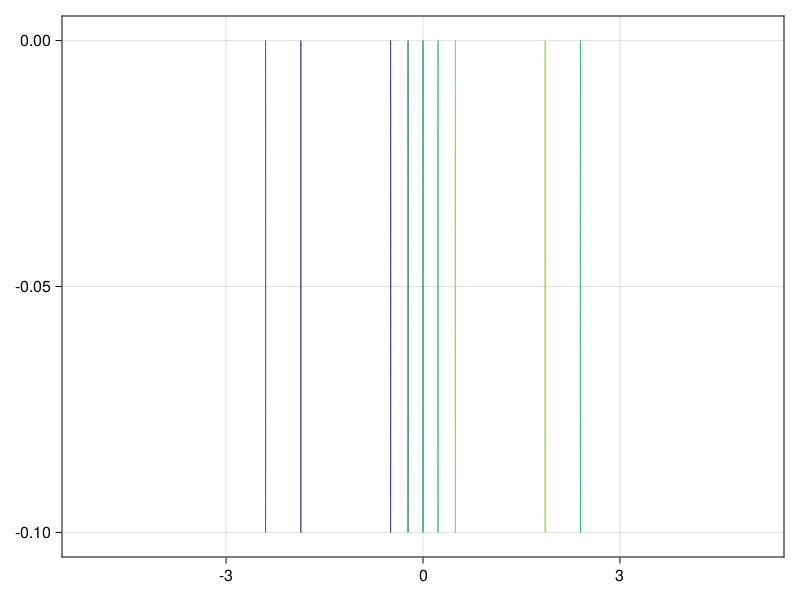

In [76]:
sp = create_simulation_parameters(; Ro=0.8, Ri=0.01, α=1.5)
(b₀, v₀) = get_filament_state(sp)
xs = range(-5sp.L, 5sp.L, 512)
zs = range(-sp.H, 0, 512);
Mmax = (b₀.(0, 0) - b₀.(-Inf, 0)) / sp.ℓ
δψ₀(x, z) = -2e-5 * (4 * (z / sp.H) * ((z / sp.H) + 1) / 3) * (b₀(x+1e-3, 0)-b₀(x-1e-3, 0)) / 2e-3 / Mmax
∇²δψ₀(x, z) = (δψ₀(x+1e-5, z) + δψ₀(x-1e-5, z) + δψ₀(x, z+1e-5) + δψ₀(x, z-1e-5) - 4*δψ₀(x, z)) / (1e-5)^2
∂v₀∂x(x, z) = (v₀(x+1e-8, z) - v₀(x-1e-8, z)) / 2e-8
∂v₀∂z(x, z) = (v₀(x, z+1e-8) - v₀(x, z-1e-8)) / 2e-8
∂b₀∂x(x, z) = (b₀(x+1e-8, z) - b₀(x-1e-8, z)) / 2e-8
∂b₀∂z(x, z) = (b₀(x, z+1e-8) - b₀(x, z-1e-8)) / 2e-8
fig = Figure()
ax = Axis(fig[1, 1])
contour!(ax, xs, zs, ∇²δψ₀)
fig

In [96]:
@parameters x z t
@variables ψ(..), ∇²ψ(..)
Dx = Differential(x)
Dz = Differential(z)
Dt = Differential(t)
Dxz = Differential(x) * Differential(z)
Dx² = Differential(x)^2
Dz² = Differential(z)^2
Dt² = Differential(t)^2
# Laplacian
@inline ∇²(a) = Dx²(a) + Dz²(a)

# Boundary in x
x_min = -2.5sp.L
x_max = 0.0
eq  = [
    Dt²(∇²ψ(x, z, t)) ~ -sp.f^2 * Dz²(ψ(x, z, t)) - sp.f*(∂v₀∂x(x, z) * Dz²(ψ(x, z, t)) - ∂v₀∂z(x, z) * Dxz(ψ(x, z, t))) + ∂b₀∂x(x, z) * Dxz(ψ(x, z, t)) - ∂b₀∂z(x, z) * Dx²(ψ(x, z, t)),
    ∇²ψ(x, z, t) ~ ∇²(ψ(x, z, t))
]
domains = [
    x ∈ Interval(x_min, x_max),
    z ∈ Interval(-sp.H, 0.0),
    t ∈ Interval(0.0, 10.0),
]
# Zero streamfunction on the boundary 
bcs = [
    ψ(x_min, z, t) ~ 0,
    ψ(x_max, z, t) ~ 0,
    ψ(x, -sp.H, t) ~ 0,
    ψ(x, 0.0, t) ~ 0,
    ∇²ψ(x_min, z, t) ~ Dx²(ψ(x_min, z, t)),
    ∇²ψ(x_max, z, t) ~ Dx²(ψ(x_max, z, t)),
    ∇²ψ(x, -sp.H, t) ~ Dz²(ψ(x, -sp.H, t)),
    ∇²ψ(x, 0.0, t) ~ Dz²(ψ(x, 0.0, t)),
    ψ(x, z, 0.0) ~ 0,
    ∇²ψ(x, z, 0.0) ~ 0,
    Dt(ψ(x, z, 0.0)) ~ δψ₀(x, z),
    Dt(∇²ψ(x, z, 0.0)) ~  ∇²δψ₀(x, z)
]

@named pdesys = PDESystem(eq, bcs, domains, [x, z, t], [ψ(x, z, t), ∇²ψ(x, z, t)]);

In [104]:
N=20
discretization = MOLFiniteDifference([x=>N, z=>N], t, approx_order=2)
prob = discretize(pdesys, discretization)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 677-element Vector{Float64}:
 -0.0015436557987278984
 -0.0018733798731190518
 -0.0022330197588968197
 -0.002613551587910651
 -0.0030016668309034494
 -0.003380738152770066
 -0.003731200448740432
 -0.004031036227080866
 -0.0042575901516610426
 -0.004388461654802926
 -0.004403977820324131
 -0.004288805947922247
 -0.004033305544813591
  ⋮
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

In [105]:
# Solve ODE problem
using OrdinaryDiffEq
sol = solve(prob, QNDF(), saveat=0.1)

LoadError: mul_float: types of a and b must match

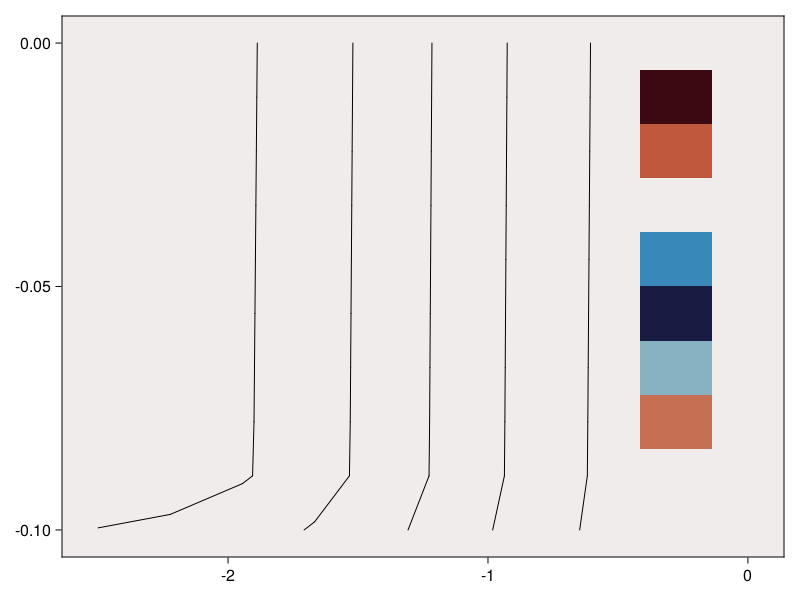

In [44]:
fig = Figure()
ax = Axis(fig[1, 1])
heatmap!(ax, sol[x], sol[z], sol.u[ψ(x, z, t)][:, :, 6], colormap=:balance)
contour!(ax, sol[x], sol[z], b₀, color=:black)
fig

In [102]:
lines(sol[t], mean(sol.u[ψ(x, z, t)]; dims=(1, 2))[1, 1, 1:10])

LoadError: BoundsError: attempt to access 1×1×1 Array{Float64, 3} at index [1, 1, 1:10]

In [103]:
sol.u[ψ(x, z, t)]

20×20×1 Array{Float64, 3}:
[:, :, 1] =
 0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0  0.0
 0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0  -0.0   0.0  -0.0   0.0  0.0
 0.0   0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0   0.0  -0.0  -0.0   0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0   0.0  -0.0  -0.0   0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0   0.0  -0.0  -0.0   0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0   0.0  -0.0  -0.0   0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0   0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  0.0
 0.0  -0.0  